In [63]:
import os
import numpy as np
import re
import tensorflow as tf
import keras

In [3]:
!unzip /content/drive/MyDrive/DL_Project/VQA_preprocessed/ImagesFeatures.zip -d /content/Features/
!mkdir /content/Features/train


Streaming output truncated to the last 5000 lines.
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000552851.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000519936.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000521988.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000247712.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000206577.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000241390.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000134490.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000567566.npy  
  inflating: /content/Features/content/ImagesFeatures/train_data/COCO_train2014_000000331409.npy  
  inflating: /content/Features/content/ImagesFeatures/trai

In [4]:
!unzip /content/drive/MyDrive/DL_Project/VQA_preprocessed/ImagesFeaturesVAL.zip -d /content/Features/val


Streaming output truncated to the last 5000 lines.
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000304596.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000158466.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000559778.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000260927.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000497002.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000197880.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000517623.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000069842.npy  
  inflating: /content/Features/val/content/ImagesFeaturesVAL/val_data/COCO_val2014_000000568425.npy  
  inflating: /content/Features/

In [12]:
INPUT_DIR = '/content/drive/MyDrive/DL_Project/VQA_preprocessed'

Vocabulary Class Definition

In [10]:
class WordIndexer:

  def __init__(self, word_list_file):
    self.word_list = self.read_words(word_list_file)
    self.index_map = {word: index for index, word in enumerate(self.word_list)}
    self.total_words = len(self.word_list)

  def read_words(self, word_list_file):
    with open(word_list_file, 'r') as file:
      words = [line.rstrip() for line in file]
    return words

  def get_index(self, word):
    return self.index_map.get(word, self.index_map.get(''))

  def get_word(self, index):
    if index < len(self.word_list) and index >= 0:
      return self.word_list[index]
    raise IndexError("Index out of range.")

In [13]:
question_vocab_file = os.path.join(INPUT_DIR, 'question_vocabs.txt')
question_indexer = WordIndexer(question_vocab_file)

answer_vocab_file = os.path.join(INPUT_DIR, 'annotation_vocabs.txt')
answer_indexer = WordIndexer(answer_vocab_file)

 Utility Functions for Loading Data and Embeddings

In [14]:
# Constants
MAX_QUESTION_LENGTH = 30

def load_numpy_array(file_path):
    return np.load(file_path, allow_pickle=True)

def split_into_tokens(text):
    pattern = re.compile(r'\W+')
    lowercased = text.lower()
    split_tokens = pattern.split(lowercased)
    tokens = [token.strip() for token in split_tokens if token.strip()]
    return tokens[:-1]

def convert_question_to_indices(question):
    question_tokens = split_into_tokens(question)
    question_indices = np.full(MAX_QUESTION_LENGTH, question_indexer.get_index(''))
    question_indices[:len(question_tokens)] = [question_indexer.get_index(token) for token in question_tokens]
    return question_indices

def convert_answer_to_one_hot(answer):
    index = answer_indexer.get_index(answer)
    one_hot_vector = np.zeros(answer_indexer.total_words)
    one_hot_vector[index] = 1
    return one_hot_vector

def process_data(feature_path, question_text, answer_text):
    feature_path = feature_path.numpy().decode('utf-8')
    question_text = question_text.numpy().decode('utf-8')
    answer_text = answer_text.numpy().decode('utf-8')

    features = load_numpy_array(feature_path)
    question_indices = convert_question_to_indices(question_text)
    answer_vector = convert_answer_to_one_hot(answer_text)

    return features, question_indices, answer_vector

def configure_tensors(features, question, answer):
    features.set_shape((49, 512))
    question.set_shape((MAX_QUESTION_LENGTH,))
    answer.set_shape((1000,))
    return (features, question), answer

def create_dataset(filename):
    directory = os.path.join(INPUT_DIR, filename)
    dataset_content = np.load(directory, allow_pickle=True).tolist()

    feature_directory = '/content/Features/content/ImagesFeatures/'
    if 'train' in filename:
        feature_directory += 'train_data/'
    elif 'val' in filename:
        feature_directory += 'val_data/'

    paths, queries, responses = [], [], []
    for item in dataset_content:
        paths.append(os.path.join(feature_directory, item[0][:-3] + 'npy'))
        queries.append(item[1])
        responses.append(item[2])

    dataset = tf.data.Dataset.from_tensor_slices((paths, queries, responses))
    BATCH_SIZE = 128
    dataset = dataset.cache()
    dataset = dataset.map(lambda x, y, z: tf.py_function(func=process_data, inp=[x, y, z], Tout=(tf.float32, tf.int32, tf.int32)), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(configure_tensors)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    return dataset


In [15]:
import numpy as np

word_embeddings = {}
mean_vector = np.zeros(300, dtype="float32")
word_count = 0

# Load the GloVe embeddings from the specified file
with open("/content/drive/MyDrive/DL_Project/glove.6B.300d.txt", 'r') as file:
    for line in file:
        parts = line.split()
        word = parts[0]
        vec = np.array(parts[1:], dtype="float32")
        word_embeddings[word] = vec
        mean_vector += vec
        word_count += 1

number_of_words = question_indexer.total_words
embedding_matrix = np.zeros((number_of_words, 300), dtype="float32")
for idx, word in enumerate(question_indexer.word_list):
    if idx < number_of_words:
        vector = word_embeddings.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector

mean_vector /= word_count
embedding_matrix[1] = mean_vector


RNN

In [86]:
import tensorflow as tf

# Constants
NUM_FEATURES = 512  # Assuming each image is represented by 512 features
IMAGE_INPUT_SHAPE = (49, NUM_FEATURES)  # 49 is the number of regions each with 512 features

# Image Model
image_input = tf.keras.layers.Input(shape=IMAGE_INPUT_SHAPE)
flattened_image = tf.keras.layers.Flatten()(image_input)
image_features = tf.keras.layers.Dense(NUM_FEATURES, activation='tanh')(flattened_image)

# Question Model using Simple RNN
QUESTION_VOCAB_SIZE = question_indexer.total_words
QUESTION_INPUT_LENGTH = MAX_QUESTION_LENGTH
question_input = tf.keras.layers.Input(shape=(QUESTION_INPUT_LENGTH,))
embedded_question = tf.keras.layers.Embedding(input_dim=QUESTION_VOCAB_SIZE,
                                              output_dim=300,
                                              input_length=QUESTION_INPUT_LENGTH,
                                              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                              trainable=True)(question_input)
question_features = tf.keras.layers.SimpleRNN(NUM_FEATURES)(embedded_question)

# Combining image and question features
combined_features = tf.keras.layers.Multiply()([image_features, question_features])

# Model Output Layer
ANSWER_VOCAB_SIZE = answer_indexer.total_words
output = tf.keras.layers.Dense(ANSWER_VOCAB_SIZE, activation='tanh')(combined_features)
output = tf.keras.layers.Dropout(0.5)(output)
final_output = tf.keras.layers.Dense(ANSWER_VOCAB_SIZE, activation='softmax')(output)

# Compile the model
model = tf.keras.Model(inputs=[image_input, question_input], outputs=final_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to check structure and parameters
model.summary()


In [88]:
import tensorflow as tf
checkpoint_path = "/content/checkpoints_features1/checkpoint-{epoch:02d}.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1

training_history_path = "/content/checkpoints_features1/history.log"
history_logger_callback = tf.keras.callbacks.CSVLogger(
    filename=training_history_path,
    append=True
)



In [89]:
train_dataset = build_dataset('/content/drive/MyDrive/DL_Project/VQA_preprocessed/train.npy')
val_dataset = build_dataset('/content/drive/MyDrive/DL_Project/VQA_preprocessed/val.npy')

history = model.fit(
    train_dataset,
    epochs=1,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, history_logger_callback]
)

3467/3467 [==============================] - ETA: 0s - loss: 2.6991 - accuracy: 0.3448

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3467/3467 [==============================] - 839s 241ms/step - loss: 2.6991 - accuracy: 0.3448 - val_loss: 2.4036 - val_accuracy: 0.3462


LSTM

In [18]:
import tensorflow as tf

# Image model
image_input = tf.keras.layers.Input(shape=(49, 512))
flattened_image = tf.keras.layers.Flatten()(image_input)
image_dense = tf.keras.layers.Dense(1024, activation='tanh')(flattened_image)

# Question model
vocab_size = question_indexer.total_words  # Adjusted to match earlier code revisions
question_input = tf.keras.layers.Input(shape=(MAX_QUESTION_LENGTH,))
embedded_question = tf.keras.layers.Embedding(input_dim=vocab_size,
                                              output_dim=300,
                                              input_length=MAX_QUESTION_LENGTH,
                                              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                              trainable=True)(question_input)
_, lstm_h, lstm_c = tf.keras.layers.LSTM(512, return_state=True)(embedded_question)
question_features = tf.keras.layers.concatenate([lstm_h, lstm_c])

# Combine features
combined_features = tf.keras.layers.Multiply()([image_dense, question_features])

# Model output
num_answers = answer_indexer.total_words  # Adjusted to match earlier code revisions
output = tf.keras.layers.Dense(num_answers, activation='tanh')(combined_features)
output = tf.keras.layers.Dropout(0.5)(output)
output = tf.keras.layers.Dense(num_answers, activation='tanh')(output)
output = tf.keras.layers.Dropout(0.5)(output)
final_output = tf.keras.layers.Dense(num_answers, activation='softmax')(output)

# Compile the model
model = tf.keras.Model(inputs=[image_input, question_input], outputs=final_output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [29]:
model_checkpoint_path = "/content/checkpoints_features/checkpoint-{epoch:02d}.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path)

training_history_path = "/content/checkpoints_features/history.log"
history_callback = tf.keras.callbacks.CSVLogger(training_history_path, append=True)


In [30]:
train_dataset = build_dataset('/content/drive/MyDrive/DL_Project/VQA_preprocessed/train.npy')
val_dataset = build_dataset('/content/drive/MyDrive/DL_Project/VQA_preprocessed/val.npy')

history = model.fit(
    train_dataset,
    epochs=15,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[model_checkpoint, history_callback]
)


Epoch 1/15
3467/3467 [==============================] - ETA: 0s - loss: 2.5036 - accuracy: 0.3598

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3467/3467 [==============================] - 852s 244ms/step - loss: 2.5036 - accuracy: 0.3598 - val_loss: 2.0678 - val_accuracy: 0.3921
Epoch 2/15
3467/3467 [==============================] - 846s 244ms/step - loss: 2.0233 - accuracy: 0.3916 - val_loss: 1.9104 - val_accuracy: 0.4109
Epoch 3/15
3467/3467 [==============================] - 847s 244ms/step - loss: 1.9020 - accuracy: 0.4064 - val_loss: 1.8602 - val_accuracy: 0.4219
Epoch 4/15
3467/3467 [==============================] - 844s 243ms/step - loss: 1.8290 - accuracy: 0.4203 - val_loss: 1.8431 - val_accuracy: 0.4262
Epoch 5/15
3467/3467 [==============================] - 845s 244ms/step - loss: 1.7782 - accuracy: 0.4301 - val_loss: 1.8372 - val_accuracy: 0.4270
Epoch 6/15
3467/3467 [==============================] - 853s 246ms/step - loss: 1.7317 - accuracy: 0.4400 - val_loss: 1.8415 - val_accuracy: 0.4294
Epoch 7/15
3467/3467 [==============================] - 854s 246ms/step - loss: 1.6900 - accuracy: 0.4489 - val_loss: 1.859

In [57]:
import matplotlib.pyplot as plt
# Epoch-wise training and validation loss
train_loss = [2.5036, 2.0233, 1.9020, 1.8290, 1.7782, 1.7317, 1.6900, 1.6498, 1.6065, 1.5644, 1.5218, 1.4821, 1.4459, 1.4133, 1.3834]
val_loss = [2.0678, 1.9104, 1.8602, 1.8431, 1.8372, 1.8415, 1.8592, 1.9023, 1.9360, 1.9662, 2.0225, 2.0702, 2.0874, 2.1546, 2.1879]

# Epoch-wise training and validation accuracy
train_accuracy = [0.3598, 0.3916, 0.4064, 0.4203, 0.4301, 0.4400, 0.4489, 0.4598, 0.4718, 0.4852, 0.4987, 0.5121, 0.5254, 0.5368, 0.5464]
val_accuracy = [0.3921, 0.4109, 0.4219, 0.4262, 0.4270, 0.4294, 0.4286, 0.4268, 0.4247, 0.4215, 0.4176, 0.4169, 0.4169, 0.4107, 0.4113]


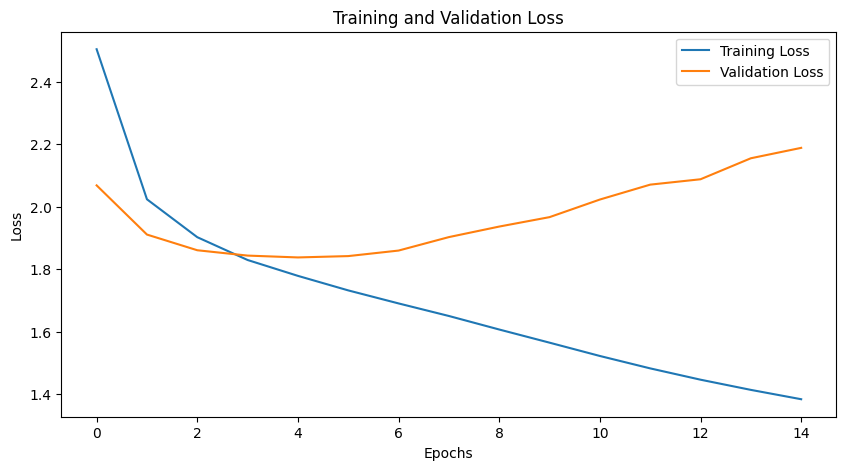

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

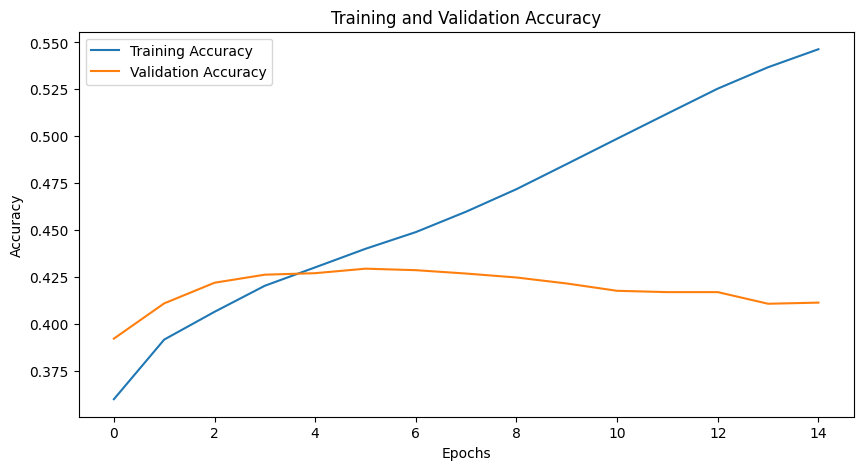

In [59]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


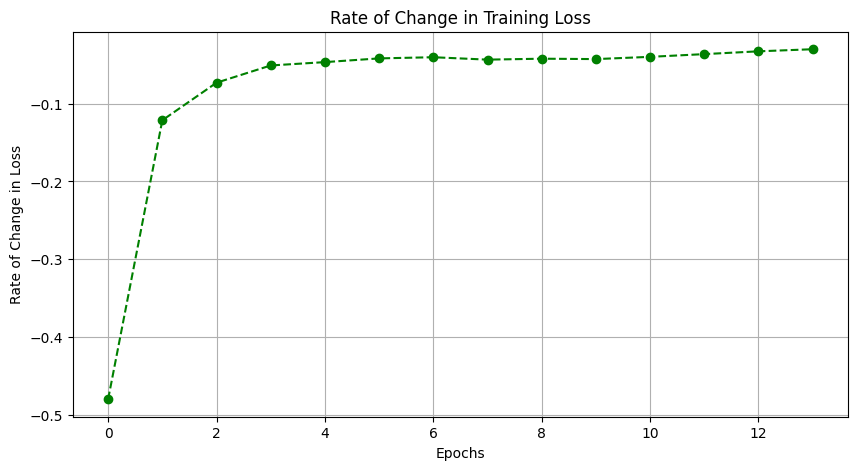

In [61]:
plt.figure(figsize=(10, 5))
rate_of_change_loss = [j-i for i, j in zip(train_loss[:-1], train_loss[1:])]
plt.plot(rate_of_change_loss, marker='o', linestyle='--', color='green')
plt.title('Rate of Change in Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Rate of Change in Loss')
plt.grid(True)
plt.show()


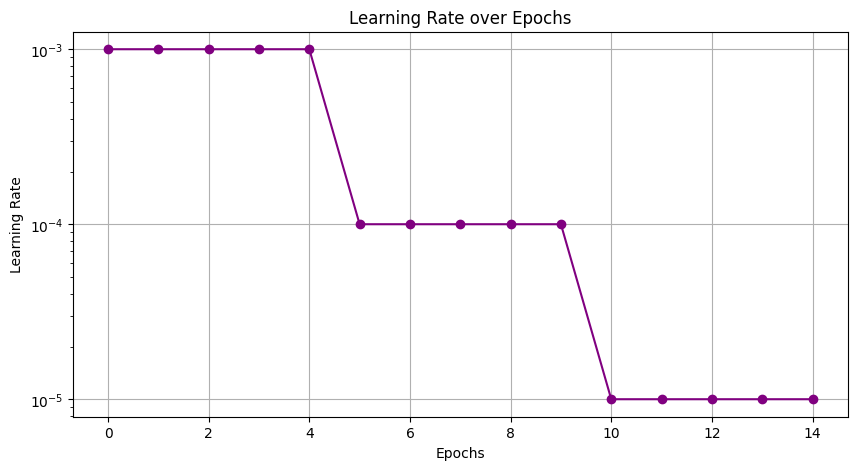

In [62]:
learning_rates = [0.001 * (0.1 ** (epoch // 5)) for epoch in range(15)]

plt.figure(figsize=(10, 5))
plt.plot(learning_rates, marker='o', linestyle='-', color='purple')
plt.title('Learning Rate over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.yscale('log')
plt.grid(True)
plt.show()


In [34]:
!zip -r "/content/drive/MyDrive/DL_Project/checkpoint-15.h5.zip" "/content/checkpoints_features/checkpoint-15.h5"


  adding: content/checkpoints_features/checkpoint-15.h5 (deflated 34%)


In [49]:
data = np.load('/content/drive/MyDrive/DL_Project/VQA_preprocessed/train.npy', allow_pickle=True).tolist()

In [54]:
image_name = data[0][1]
que = data[1][1]
answer = data[0][2]

In [52]:
print(que, answer)

What position is this man playing? net


In [56]:
!zip -r "/content/drive/MyDrive/DL_Project/checkpoint-04.h5.zip" "/content/checkpoints_features/checkpoint-04.h5"


  adding: content/checkpoints_features/checkpoint-04.h5 (deflated 33%)


In [46]:
img_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

In [ ]:
import tensorflow as tf

vqa_model_path = '/content/checkpoints_features/checkpoint-01.h5'
vqa_model = tf.keras.models.load_model(vqa_model_path)



In [ ]:
# Setup the full VQA model architecture
img_input = tf.keras.layers.Input(shape=(224, 224, 3))
image_features = img_model(img_input)
image_features_reshaped = tf.keras.layers.Reshape((49, 512))(image_features)

question_input = tf.keras.layers.Input(shape=(30,), dtype=tf.int64)
output = vqa_model([image_features_reshaped, question_input])

full_model = tf.keras.models.Model(inputs=[img_input, question_input], outputs=output)


In [1]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.vgg16.preprocess_input(img)
    return img

In [2]:
def load_question(question):
  qu_tokens = tokenizer(question)
  qu2idx = np.full(max_qu_length, question_vocab.word2idx(''))
  qu2idx[:len(qu_tokens)] = [question_vocab.word2idx(token) for token in qu_tokens]
  return qu2idx

In [5]:
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/DL_Project/VQA_model.tflite")
interpreter.allocate_tensors()


In [6]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [43]:
img = load_image('/content/pic.jpg')
que = load_question('what colour is the shirt?')

# Resize and cast data as required by the input_details
img = tf.expand_dims(img, axis=0).numpy().astype(input_details[1]['dtype'])
que = tf.expand_dims(que, axis=0).numpy().astype(input_details[0]['dtype'])


In [44]:
interpreter.set_tensor(input_details[0]['index'], que)
interpreter.set_tensor(input_details[1]['index'], img)


In [45]:
interpreter.invoke()


In [46]:
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_label_idx = tf.argmax(output_data, axis=1).numpy()[0]
predicted_label = answer_vocab.idx2word(predicted_label_idx)


In [47]:
print(f"Predicted answer: {predicted_label}")


Predicted answer: red and yellow
